## Generates mass function for sim dataset
## Generates mass-luminosity relationships

The mass function will be a figure in the paper.

In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from useful_functions.plotter import plot, loglogplot
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

In [2]:
data_dir = '../data/'
fig_dir  = '../figs/'

In [3]:
data = np.load(data_dir+'clusterList.npy')#pd.read_csv('SGclusterList.csv')

In [4]:
data.dtype.names

('id',
 'snap_id',
 'snapnum',
 'uid',
 'x',
 'y',
 'z',
 'x_pixel',
 'y_pixel',
 'i_sector',
 'M500_msolh',
 'r500_kpch',
 'gas_frac',
 'star_frac',
 'T_kev',
 'Lx_ergs',
 'Y500c',
 'M_sat_M_cD',
 'cshift',
 'vx',
 'vy',
 'vz',
 'R500_pixel',
 'R500_deg',
 'simname',
 'Tobs',
 'Dcomoving_Mpch',
 'redshift',
 'simRan')

In [7]:
excised_lx = np.loadtxt(data_dir+'excised_lx.txt')

Text(0, 0.5, 'count')

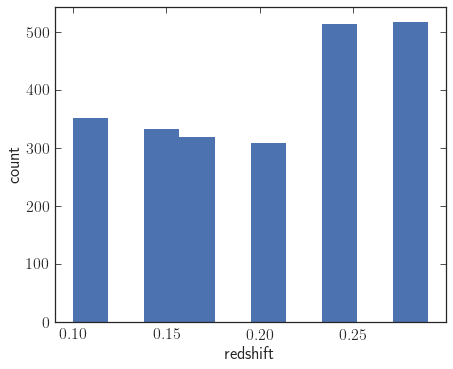

In [8]:
fig, ax = plot()
plt.hist(data['redshift'])
plt.xlabel('redshift'); plt.ylabel('count')
#plt.savefig(fig_dir+'redshift_dist.pdf',bbox_inches='tight')

In [9]:
#binseq = np.logspace(13.5,15,16)
bin_count = 13
binseq = np.logspace(13.5,14.8,bin_count + 1)
bincenters = 0.5*(binseq[1:]+binseq[:-1])
binsize=np.zeros(len(bincenters))
for j in range(0,len(bincenters)):
    binsize[j] = binseq[j+1] - binseq[j]

In [10]:
masses = data['M500_msolh']
len(masses)

2343

In [11]:
binseq

array([3.16227766e+13, 3.98107171e+13, 5.01187234e+13, 6.30957344e+13,
       7.94328235e+13, 1.00000000e+14, 1.25892541e+14, 1.58489319e+14,
       1.99526231e+14, 2.51188643e+14, 3.16227766e+14, 3.98107171e+14,
       5.01187234e+14, 6.30957344e+14])

In [12]:
np.min(np.log10(data["M500_msolh"])) #cutoff at 13.5, largest at 14.7

13.500118

In [13]:
massFunc = np.zeros(bin_count) #i.e. number per bin
for i in range(0,len(massFunc)):
    massFunc[i] = len(masses[np.logical_and(masses >= binseq[i], masses < binseq[i+1])])

In [14]:
massFunc

array([226., 229., 242., 253., 264., 389., 280., 220., 114.,  66.,  31.,
        17.,  12.])

In [15]:
np.sum(massFunc)

2343.0

In [16]:
bins_to_use = np.log10(binseq)

[226. 229. 242. 253. 264. 389. 280. 220. 114.  66.  31.  17.  12.]


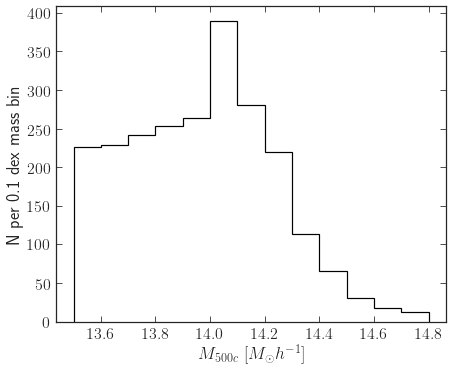

In [17]:
fig, ax = plot()
n, bins, patches = plt.hist(np.log10(masses),histtype='step',linewidth=1.2, color='k', bins = bins_to_use)#int(np.sqrt(len(masses))))
print(n)
plt.ylabel(r'N per 0.1 dex mass bin')
plt.xlabel(r'$M_{500c}$ $[M_\odot h^{-1}]$')
#plt.title('Magneticum mass function run Jan. 9')
plt.savefig(fig_dir+'mass_func.pdf',bbox_inches='tight')
#I like this look, but not sure

#Should we eventually plot this as dN/dlnM instead, or is this as a histogram okay?

Text(0, 0.5, 'Original Lx')

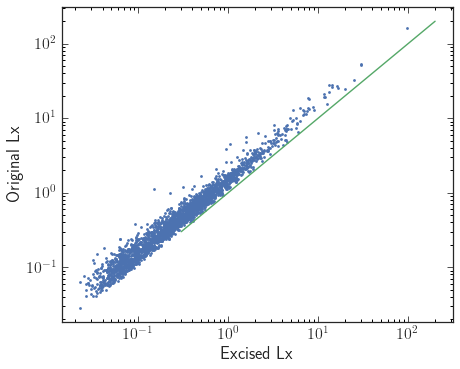

In [18]:
fig, ax = loglogplot()
plt.plot(excised_lx[:,1], data['Lx_ergs'], '.')
plt.plot([3e-1,2e2],[3e-1,2e2])
plt.xlabel('Excised Lx')
plt.ylabel('Original Lx')
#looking better after excising

#clearly, the excision reduces... but it doesn't seem to deal with the ridiculous outliers!
#obviously still need to do this with the true, no background images, and then again with the observed Lx values

[1.7100133] -24.237703
[-24.237703, array([1.7100133], dtype=float32)]
0.48898068
mass scatter 0.1241871


Text(30000000000000.0, 30.0, ' $M_{500c}$ Scatter: 0.12')

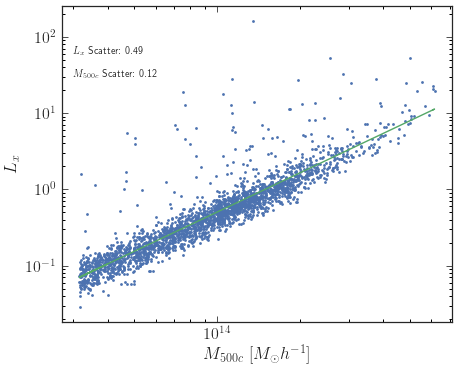

In [19]:
#let's verify the redshift scaling
#first do a scatter plot of mass vs. luminosity unscaled

#no core excise, no redshift scale

omega_l = 0.728
omega_m = 0.272

def E(z):
    return np.sqrt((1+z)**3 * omega_m + omega_l)

def linear_fit(x, *p):
    return 10**(np.log10(p[0])+(p[1])*(np.log10(x)))

def log_linear_fit(x, *p):
    return p[0] + p[1]*x

def scatter(M1,M2):
    #calculates the residuals and takes the std dev of them to return the scatter in fractional form
    #return np.std(np.log(M1/M2))
    return (np.percentile(np.log(M1/M2),84) - np.percentile(np.log(M1/M2),16)) / 2.

def M500c_from_Lx(Lx,z,h): #what units for Lx?
    #p1 = (h/0.72)**((5*B_YM/2)-1) * C_YM * E(z)**(a_YM) * (Lx / (C_LY * E(z)**a_LY))**(B_YM / B_LY)
    #return p1 / (10**14)
    Mstar = 4e14 #in 10**14 units
    alpha = 7.0/3.0
    B=1.63
    C=3.5 #luminosity is in 10**44 units
    return (Lx / (C*E(z)**alpha))**(1/B) * Mstar

fig, ax = loglogplot()
mass = data['M500_msolh']
Lx = data['Lx_ergs']

reg = LinearRegression().fit(np.log10(mass).reshape(-1, 1), np.log10(Lx))
print(reg.coef_, reg.intercept_)
popt_log = [reg.intercept_, reg.coef_]
print(popt_log)
model_fit = 10**log_linear_fit(np.log10(mass), *popt_log)
#not sure why the curve fit doesn't work the other way...

residuals = np.log(Lx / model_fit)
scatter = np.std(residuals)
print(scatter)

mass_preds = (10**(-1.*reg.intercept_) * Lx)**(1./reg.coef_)
mass_res = np.log10(mass_preds) - np.log10(mass)
mass_scatter = np.std(mass_res)
print("mass scatter",mass_scatter) #11.4%, not bad

#should both be lined up
plt.plot(mass, Lx, '.', rasterized=True)
plt.plot(mass, model_fit)
plt.xlabel('$M_{500c}$ $[M_\odot h^{-1}]$')
plt.ylabel(r'$L_x$')
plt.text(3e13,6e1,' $L_x$ Scatter: %.2f'%scatter)
plt.text(3e13,3e1,' $M_{500c}$ Scatter: %.2f'%mass_scatter)
#plt.savefig('m_Lx_no_scale_no_ex.pdf',bbox_inches='tight')

[1.7512048] -25.017433
0.47434169745000815
mass scatter 0.1176355675201528


Text(30000000000000.0, 30.0, ' $M_{500c}$ Scatter: 0.12')

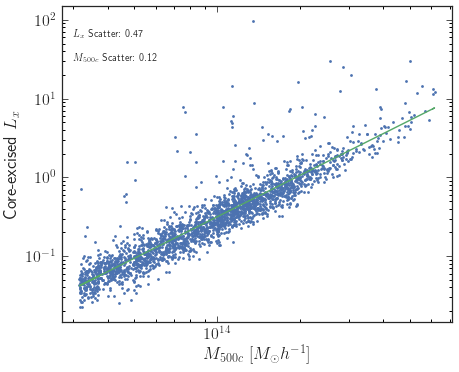

In [20]:
#core excised, no redshift scale

fig, ax = loglogplot()
mass = data['M500_msolh']
Lx = excised_lx[:,1] #data['Lx_ergs']

#do the fit
#not sure why the curve fit doesn't work the other way...

reg = LinearRegression().fit(np.log10(mass).reshape(-1, 1), np.log10(Lx))
print(reg.coef_, reg.intercept_)
popt_log = [reg.intercept_, reg.coef_]
model_fit = 10**log_linear_fit(np.log10(mass), *popt_log)

#this is the best fit in log space, but we may also want to do best fit in linear space...
#not really sure how this is done, but this is what we got

#scatter is slightly reduced, but not amazingly so


residuals = np.log(Lx / model_fit)
scatter = np.std(residuals)
print(scatter)

mass_preds = (10**(-1.*reg.intercept_) * Lx)**(1./reg.coef_)
mass_res = np.log10(mass_preds) - np.log10(mass)
mass_scatter = np.std(mass_res)
print("mass scatter",mass_scatter) #11.4%, not bad


#should both be lined up
plt.plot(mass, Lx, '.', rasterized=True)
plt.plot(mass, model_fit)
plt.xlabel('$M_{500c}$ $[M_\odot h^{-1}]$')
plt.ylabel(r'Core-excised $L_x$')
plt.text(3e13,6e1,' $L_x$ Scatter: %.2f'%scatter)
plt.text(3e13,3e1,' $M_{500c}$ Scatter: %.2f'%mass_scatter)
#plt.savefig('m_Lx_no_scal_excise.pdf',bbox_inches='tight')

#scatter didn't go down as low as I thought... gotta wait and see what happens with Maughan
#would like to be able to reproduce the ~17% scatter that they report

#now what we want is to calculate the scatter between the mass predictions
#mass_predictions = 

#we're getting a scatter of 0.12, but we're getting a scatter of 10.6 if we use the test dataset after training
#on the training dataset
#is this just because there is a smaller number of data points?
#how do we normalize scatter by number of data points?
#well, it's actually irreleveant if you have a large enough sample size since its the std...

[1.7862227] -25.601068
[-25.601068, array([1.7862227], dtype=float32)]
0.46352011032831664
mass scatter 0.11269827856420858
maughan scatter 0.12611591647007048


Text(30000000000000.0, 15.0, ' Maughan $M_{500c}$ Scatter: 0.13')

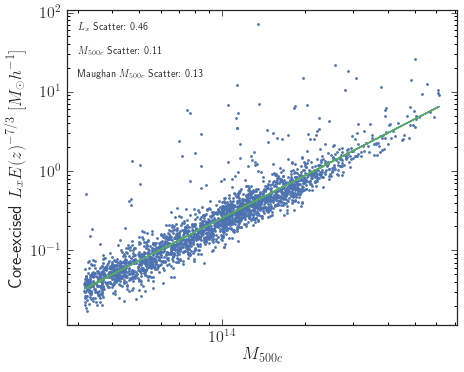

In [21]:
#redshift scaled, core-excised

fig, ax = loglogplot()
redshift = data['redshift']
Lx = excised_lx[:,1]
plt.plot(mass, Lx*E(redshift)**(-7./3.), '.')#, rasterized=True)

reg = LinearRegression().fit(np.log10(mass).reshape(-1, 1), np.log10(Lx*E(redshift)**(-7./3.)))
print(reg.coef_, reg.intercept_)
popt_log = [reg.intercept_, reg.coef_]
print(popt_log)
model_fit = 10**log_linear_fit(np.log10(mass), *popt_log)
#not sure why the curve fit doesn't work the other way...

residuals = np.log(Lx*E(redshift)**(-7./3.) / model_fit)
scatter = np.std(residuals)
print(scatter)

mass_preds = (10**(-1.*reg.intercept_) * Lx * E(redshift)**(-7./3.))**(1./reg.coef_)
mass_res = np.log10(mass_preds) - np.log10(mass)
mass_scatter = np.std(mass_res)
print("mass scatter",mass_scatter) #11.4%, not bad; core-excision does make a positive difference

#maughan
maughan_preds = M500c_from_Lx(Lx,redshift,h=0.704)
maughan_res = np.log10(maughan_preds) - np.log10(mass)
maughan_scatter = np.std(maughan_res)
print("maughan scatter",maughan_scatter) #very consistent, so justifies our fitting method 11.4 vs 11.9%
#so we report a 12% scatter using standard regression, can make pdfs of the scatter at some point
#just need to decide if we want to use redshift scaling or not
#also need to decide which maughan function we want to use

#these are the parameters that we would want to use, although we need to make sure that it should be done in
#log vs log space, instead of doing a legitimate fit of the parameters as a linear fit
#now let's invert the relation and predict the masses, then calculate mass residuals

#TODO: do we want to report scatter from Mass-Luminosity with or without (redshift) and (core-excision)
#ADDITIONAL: is fitting linearly the logarithmic quantities OK or do we need to do it the other way?
#one way minimizes least-squares error on the logs of quantities (way that I'm doing it) and the other
#way minimizes the least-squares error of the quantities themselves (seems to be the right way...)

plt.plot(mass, model_fit)
plt.xlabel('$M_{500c}$')
plt.ylabel(r'Core-excised $L_x E(z)^{-7/3}$ $[M_\odot h^{-1}]$')
plt.text(3e13,6e1,' $L_x$ Scatter: %.2f'%scatter)
plt.text(3e13,3e1,' $M_{500c}$ Scatter: %.2f'%mass_scatter)
plt.text(3e13,1.5e1,' Maughan $M_{500c}$ Scatter: %.2f'%maughan_scatter)
#plt.savefig('m_Lx_z_scale_core_ex.pdf',bbox_inches='tight')

#a lot of these guys are way brighter than they should be
#this is because we need to excise the cores...

/home/sbg/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


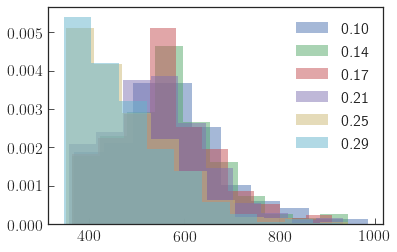

In [22]:
z = np.unique(data['redshift'])
for i in range(0,len(z)):
    plt.hist(data['r500_kpch'][np.where(data['redshift'] == z[i])[0]] / (1.+z[i]),label='%.2f'%z[i],alpha=0.5,normed=True)
plt.legend()

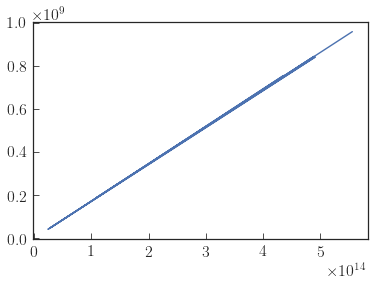

In [23]:
plt.plot(data['M500_msolh']/ E(data['redshift'])**2, data['r500_kpch']**3 / (1+data['redshift'])**3)
#the radii are indeed comoving
#but what are the degrees/pixels? 
#how do they scale between? how do we add scatter to radii to make everything consistent?

In [24]:
h=0.704 #from Magneticum data
R500_pixel_added_scatter = data['R500_pixel'] + np.random.normal(0.0,0.03*data['R500_pixel'])
#r500_kpc_phys = (data['r500_kpch'] / h) / (1. + data['redshift'])

#it's originally comoving

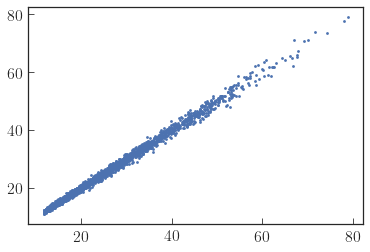

In [25]:
plt.plot(data['R500_pixel'], R500_pixel_added_scatter,'.')

In [26]:
#scatter
h=0.704 #from Magneticum data
r500_kpc_phys = (data['r500_kpch'] / h) / (1. + data['redshift'])
r500_kpc_phys_scatter = r500_kpc_phys + np.random.normal(0.0,0.03*r500_kpc_phys)
R500_pixel_added_scatter = data['R500_pixel'] * r500_kpc_phys_scatter / r500_kpc_phys
for_lorenzo = np.column_stack((data['id'],r500_kpc_phys_scatter, R500_pixel_added_scatter, data['redshift']))
np.savetxt('cluster_data_rscatter.dat',for_lorenzo,fmt=['%d','%f','%f','%f'])

In [54]:
#no scatter
h=0.704 #from Magneticum data
r500_kpc_phys = (data['r500_kpch'] / h) / (1. + data['redshift']) #was originally comoving kpc/h, so divide by h*(1+z)
for_lorenzo = np.column_stack((data['id'],r500_kpc_phys, data['R500_pixel'], data['redshift']))
np.savetxt('cluster_data.dat',for_lorenzo,fmt=['%d','%f','%f','%f'])